## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
human_idmapping_dat = "/users/aeg/Downloads/HUMAN_9606_idmapping.dat"
mouse_idmapping_dat="/users/aeg/Downloads/MOUSE_10090_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [2]:
!cp $human_idmapping_dat $idmapping_dat
!cat $mouse_idmapping_dat >> $idmapping_dat
!wc -l $idmapping_dat

cat: /users/aeg/Downloads/MOUSE_10090_idmapping.dat: No such file or directory
 6069354 ./tmpmap.dat


In [3]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [4]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [5]:
download_single_file(s3_data, data_file)

In [6]:
download_single_file(s3_annotations, annotations_file)

In [7]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [8]:
data.pubmedId.nunique()

850

In [9]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [10]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [11]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
10,575312,phosphorylation,"[{'uniprotid': 'P02686-1', 'alias': [['p02686-1'], ['Myelin basic protein'], ['MBP'], ['Myelin A1 protein'], ['Myelin membrane encephalitogenic protein'], ['Golli-MBP1'], ['HOG7']], 'alternative_uniprots': []}, {'uniprotid': 'Q8I629', 'alias': [['q8i629_plaf7'], ['PF3D7_1201600']], 'alternative_uniprot

In [12]:
data.shape

(3381, 7)

In [13]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


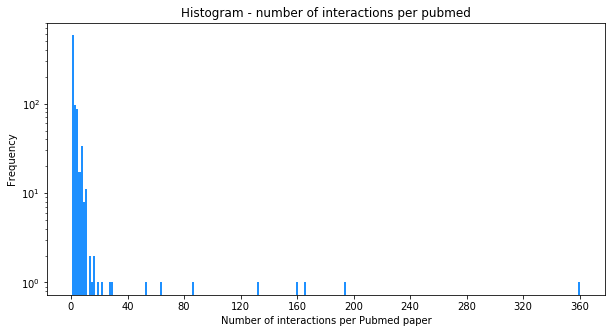

In [14]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

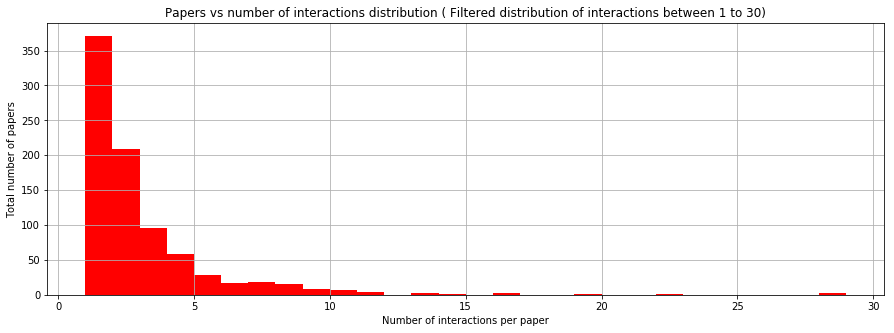

In [15]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

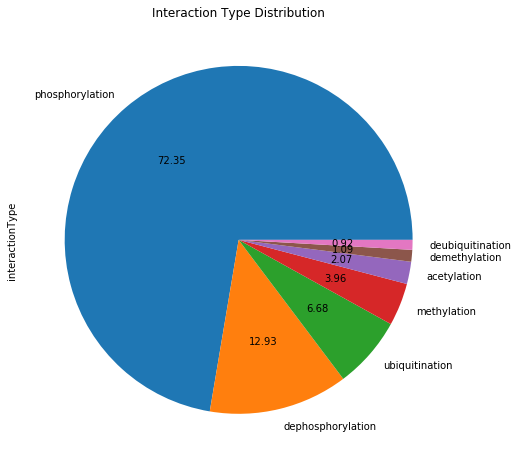

In [16]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [17]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

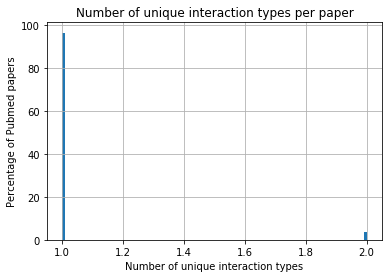

In [18]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

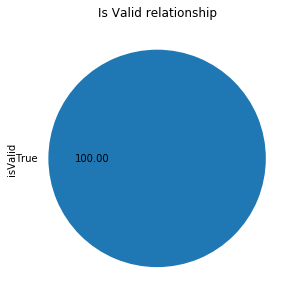

In [19]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

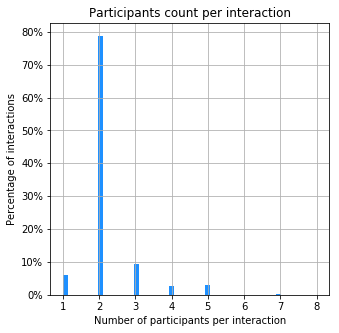

In [20]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [21]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

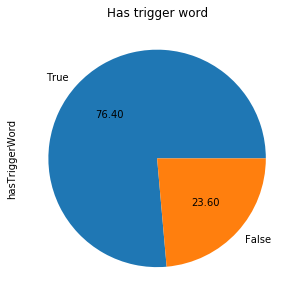

In [22]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

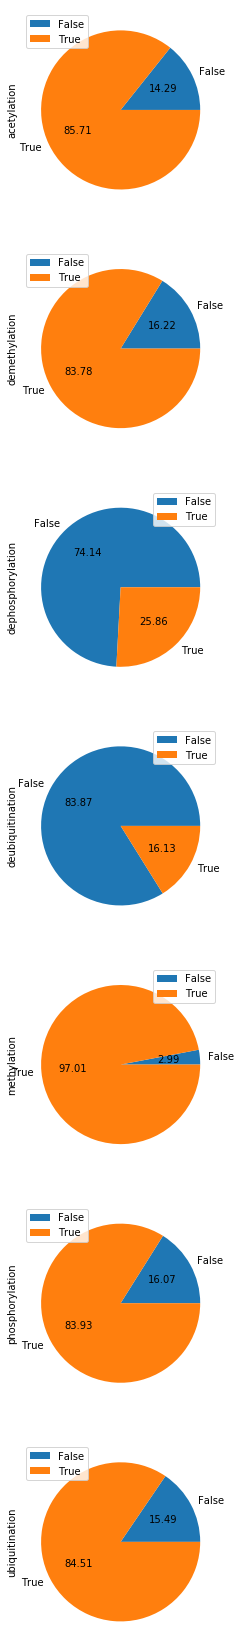

In [23]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [24]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 25.1 s, sys: 137 ms, total: 25.2 s
Wall time: 26.1 s


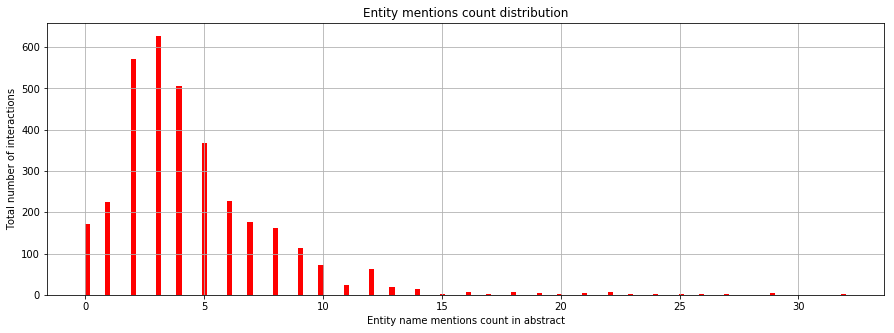

In [25]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

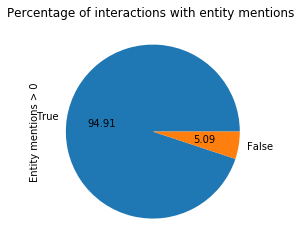

In [26]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [27]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
699,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'O00629', 'alias': [['ima3_human'], ['Importin subunit alpha-3'], ['KPNA4'], ['QIP1'], ['Karyopherin subunit alpha-4'], ['Importin alpha Q1']], 'alternative_uniprots': ['O00190', 'A8K4S6', 'D3DNM2']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
718,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'P49736', 'alias': [['mcm2_human'], ['DNA replication licensing factor MCM2'], ['MCM2'], ['BM28'], ['CDCL1'], ['KIAA0030'], ['Minichromosome maintenance protein 2 homolog'], ['Nuclear protein BM28'], ['CCNL1']], 'alternative_uniprots': ['Q969W7', 'Q8N2V1', 'Q96AE1', 'Q9BRM7', 'Q15023', 'Q14577']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
1219,"[{'uniprotid': 'Q9UBS0', 'alias': [['ks6b2_human'], ['Ribosomal protein S6 kinase beta-2'], ['RPS6KB2'], ['STK14B'], ['70 kDa ribosomal protein S6 kinase 2'], ['S6 kinase-related kinase'], ['Serine/threonine-protein kinase 14B'], ['p70 ribosomal S6 kinase beta']], 'alternative_uniprots': ['B2RMZ9', 'Q9UEC1', 'B4DML8', 'O94809']}, {'uniprotid': 'P62753', 'alias': [['rs6_human'], ['40S ribosomal protein S6'], ['RPS6'], ['Phosphoprotein NP33'], ['Small ribosomal subunit protein eS6'], ['OK/SW-cl.2']], 'alternative_uniprots': ['Q4VBY7', 'P08227', 'P10660', 'Q8N6Z7']}]","Patients with small cell lung cancer (SCLC) die because of chemoresistance. Fibroblast growth factor-2 (FGF-2) increases the expression of antiapoptotic proteins, XIAP and Bcl-X(L), and triggers chemoresistance in SCLC cells. Here we show that these effects are mediated through the formation of a specific multiprotein complex comprising B-Raf, PKCepsilon and S6K2. S6K1, Raf-1 and other PKC isoforms do not form similar complexes. RNAi-mediated downregulation of B-Raf, PKCepsilon or S6K2 abolishes FGF-2-mediated survival. In contrast, overexpression of PKCepsilon increases XIAP and Bcl-X(L) levels and chemoresistance in SCLC cells. In a tetracycline-inducible system, increased S6K2 kinase activity triggers upregulation of XIAP, Bcl-X(L) and prosurvival effects. However, increased S6K1 kinase activity has no such effect. Thus, S6K2 but not

In [28]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9


## Data Transformation

### Filter interactions with more than 2 participants

In [29]:
filtered = data.query('participants_count <= 2')
filtered.shape

(2868, 10)

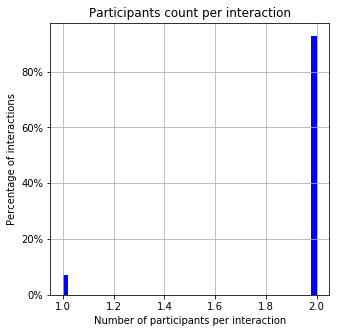

In [30]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Filter out interactions from paper with more than 15 interactions

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


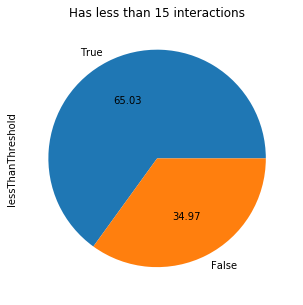

In [31]:
pubmed_interaction_count = filtered.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


#interactions_count= pd.DataFrame()
filtered["lessThanThreshold"] = filtered.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


filtered.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [32]:
filtered = filtered.query("lessThanThreshold == 1")

In [33]:
print("Total number of records after filter: {}".format(filtered.shape[0]))

Total number of records after filter: 1865


###  Flatten partcipants into participant 1 and particpiant 2

In [34]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [35]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


In [36]:
data_transformed.shape

(1865, 14)

### Remove records where the alias is null

In [37]:
data_transformed.shape

(1865, 14)

In [38]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull()]
data_filtered.shape

(1795, 14)

In [39]:
data_filtered = data_filtered[data_filtered.participant2Id.notnull()]
data_filtered.shape

(1766, 14)

In [40]:
data_filtered.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


### Normalise abstract

In [41]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        #mapper = NcbiGeneUniprotMapper()
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.textGeneNormaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [42]:
%%time
data_filtered = normalise_absract(data_filtered, annotations_file)

CPU times: user 4.12 s, sys: 147 ms, total: 4.26 s
Wall time: 4.66 s


In [43]:
data_filtered.shape

(1766, 15)

In [44]:
data_filtered.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.","O43293-2 (O43293-2) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293-2 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293-2 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to Q10728(Q10728) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293-2 to Q10728 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to Q10728, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as h

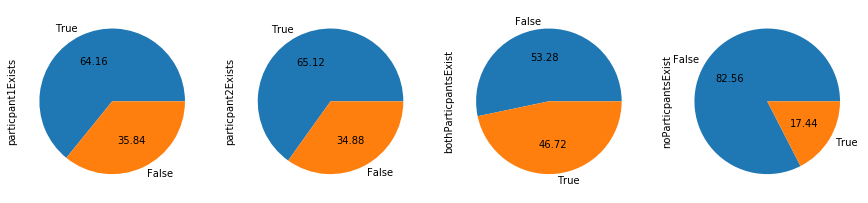

In [45]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


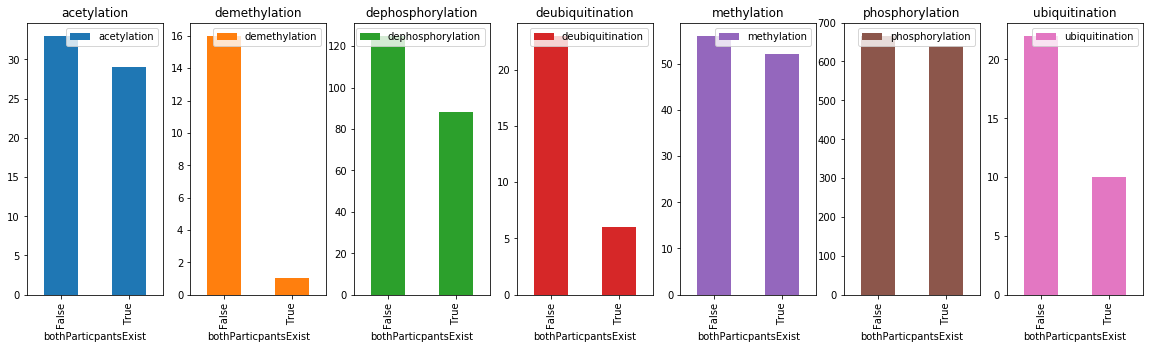

In [46]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [47]:
data_filtered.query("particpant2Exists == False").sample(4)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1183,8,True,7622,ubiquitination,True,True,"[[rnf12_human], [E3 ubiquitin-protein ligase RLIM], [RING-type E3 ubiquitin transferase RLIM], [RLIM], [RNF12], [RING finger protein 12], [LIM domain-interacting RING finger protein], [RING finger LIM domain-binding protein], [Renal carcinoma antigen NY-REN-43]]",Q9NVW2,"[[ldb2_human], [LIM domain-binding protein 2], [LDB2], [CLIM1], [Carboxyl-terminal LIM domain-binding protein 1], [LIM domain-binding factor CLIM1]]",O43679,2,11882901,None,"The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with RLIM (RING finger LIM domain-binding protein) and with CLIM (cofactor of LIM-HD proteins; also known as NLI, Ldb and Chip) cofactors. The co-repressor RLIM inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify RLIM as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of RLIM with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.","The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with Q9NVW2 (Q9NVW2) and with CLIM (cofactor of LIM-HD proteins; also known as Q86U70, Ldb and Chip) cofactors. The co-repressor Q9NVW2 inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify Q9NVW2 as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of Q9NVW2 with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.",True,False,False,False
544,3,True,1216352,phosphorylation,True,True,"[[ron_mouse], [Macrophage-stimulating protein receptor], [Mst1r], [Ron], [Stk], [Stem cell-derived tyrosine kinase], [p185-Ron]]",Q62190,"[[ctnb1_human], [Catenin beta-1], [Beta-catenin], [OK/SW-cl.35], [PRO2286], [CTNNB1], [CTNNB]]",P35222,2,21423209,None,"Our previous studies demonstrated that selective overexpression of the Ron receptor tyrosine kinase in the murine mammary epithelium leads to mammary tumor formation. Biochemical analysis of mammary tumor lysates showed that Ron overexpression was associated with increases in β-catenin expression and t

### Remove abstracts where both participants do not exists

In [48]:
data_filtered =  data_filtered.query('particpant2Exists == True')
data_filtered.shape

(1150, 19)

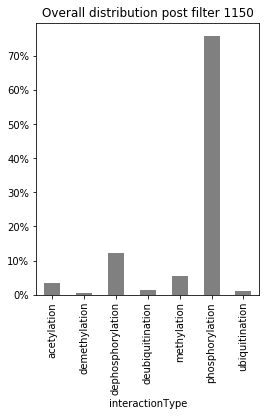

In [49]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

### Split Train/Test/validation

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [51]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array(['23219879', '17320160', '17805299', '17567753'], dtype=object)

In [52]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15678106', '15710384', '14603323',
       '12878161', '12230472', '11588219', '11894096', '11882901',
       '19656744', '16601676', '11027293'], dtype=object)

In [53]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [54]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '15710384', '12878161', '12230472',
       '11588219', '19656744', '16601676', '11027293'], dtype=object)

In [55]:
val.query("interactionType == 'ubiquitination'")


,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1181,8,True,7618,ubiquitination,True,True,"[[rnf12_human], [E3 ubiquitin-protein ligase RLIM], [RING-type E3 ubiquitin transferase RLIM], [RLIM], [RNF12], [RING finger protein 12], [LIM domain-interacting RING finger protein], [RING finger LIM domain-binding protein], [Renal carcinoma antigen NY-REN-43]]",Q9NVW2,"[[ldb1_human], [LIM domain-binding protein 1], [Nuclear LIM interactor], [Carboxyl-terminal LIM domain-binding protein 2], [LIM domain-binding factor CLIM2], [LDB1], [CLIM2]]",Q86U70,2,11882901,None,"The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with RLIM (RING finger LIM domain-binding protein) and with CLIM (cofactor of LIM-HD proteins; also known as NLI, Ldb and Chip) cofactors. The co-repressor RLIM inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify RLIM as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of RLIM with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.","The interactions of distinct cofactor complexes with transcription factors are decisive determinants for the regulation of gene expression. Depending on the bound cofactor, transcription factors can have either repressing or transactivating activities. To allow a switch between these different states, regulated cofactor exchange has been proposed; however, little is known about the molecular mechanisms that are involved in this process. LIM homeodomain (LIM-HD) transcription factors associate with Q9NVW2 (Q9NVW2) and with CLIM (cofactor of LIM-HD proteins; also known as Q86U70, Ldb and Chip) cofactors. The co-repressor Q9NVW2 inhibits the function of LIM-HD transcription factors, whereas interaction with CLIM proteins is important for the exertion of the biological activity conferred by LIM-HD transcription-factors. Here we identify Q9NVW2 as a ubiquitin protein ligase that is able to target CLIM cofactors for degradation through the 26S proteasome pathway. Furthermore, we demonstrate a ubiquitination-dependent association of Q9NVW2 with LIM-HD proteins in the presence of CLIM cofactors. Our data provide a mechanistic basis for cofactor exchange on DNA-bound transcription factors, and probably represent a general mechanism of transcriptional regulation.",True,True,True,False


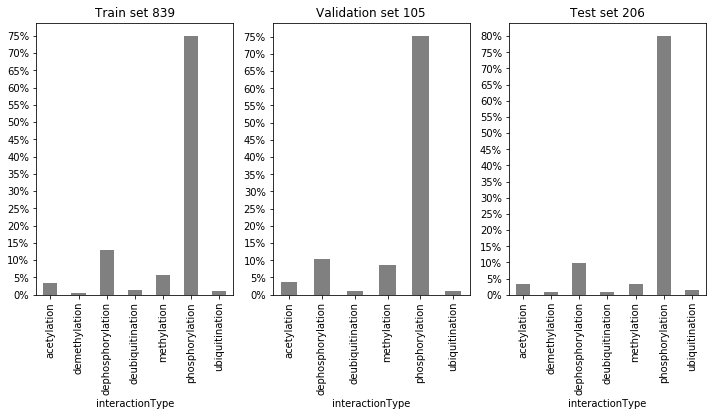

In [56]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

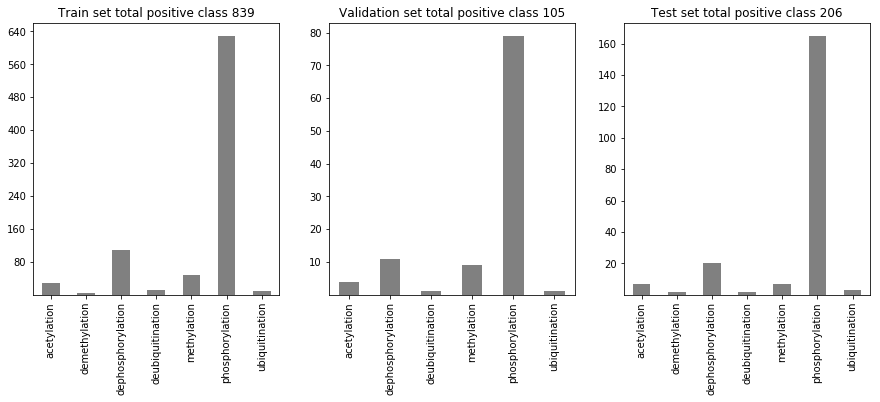

In [57]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Generate negative samples

In [58]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [59]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [60]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [61]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [62]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [63]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



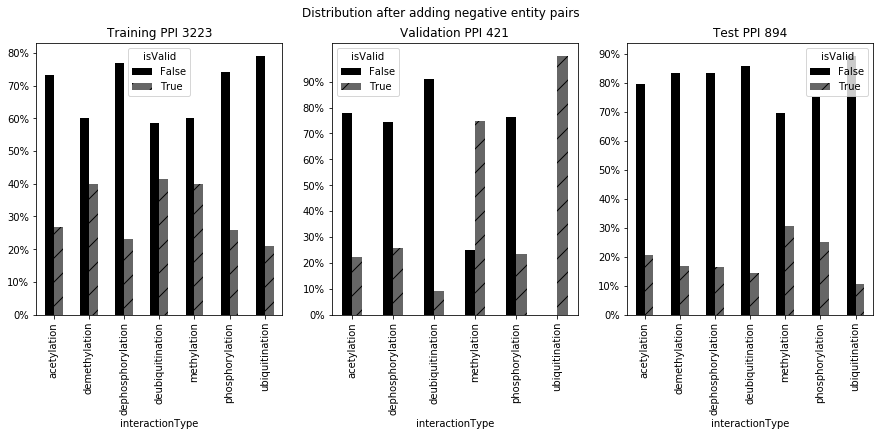

In [64]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

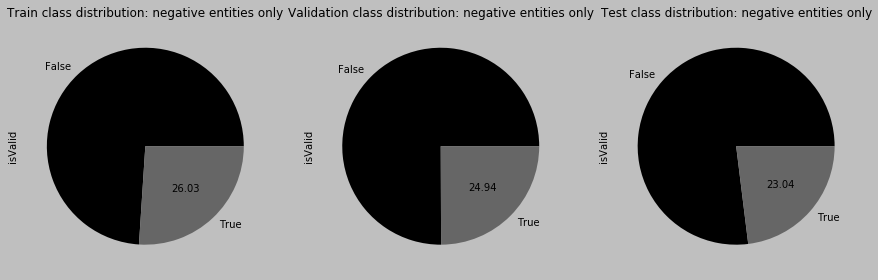

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [66]:
train.to_json("train_unique_negative_entity_only.json")
test.to_json("test_unique_negative_entity_only.json")
val.to_json("val_unique_negative_entity_only.json")



In [67]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,79,29
demethylation,6,4
dephosphorylation,362,108
deubiquitination,17,12
methylation,72,48
phosphorylation,1814,629
ubiquitination,34,9


In [68]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,14.0,4.0
dephosphorylation,32.0,11.0
deubiquitination,10.0,1.0
methylation,3.0,9.0
phosphorylation,257.0,79.0
ubiquitination,NaN,1.0


In [69]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,27,7
demethylation,10,2
dephosphorylation,101,20
deubiquitination,12,2
methylation,16,7
phosphorylation,497,165
ubiquitination,25,3


In [70]:
feature_cols = ["pubmedabstract", "normalised_abstract", "participant1Id", "participant2Id", "interactionType", "isValid"]
derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [71]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [72]:
feature_cols = ["pubmedabstract", "normalised_abstract", "participant1Id", "participant2Id", "class"]


train_multiclass = train_multiclass[ feature_cols]
test_multiclass = test_multiclass[ feature_cols]
val_multiclass = val_multiclass[ feature_cols]




In [73]:
train_multiclass["class"].value_counts()

other                2384
phosphorylation       629
dephosphorylation     108
methylation            48
acetylation            29
deubiquitination       12
ubiquitination          9
demethylation           4
Name: class, dtype: int64

In [74]:
test_multiclass["class"].value_counts()

other                688
phosphorylation      165
dephosphorylation     20
acetylation            7
methylation            7
ubiquitination         3
demethylation          2
deubiquitination       2
Name: class, dtype: int64

In [75]:
val_multiclass["class"].value_counts()

other                316
phosphorylation       79
dephosphorylation     11
methylation            9
acetylation            4
deubiquitination       1
ubiquitination         1
Name: class, dtype: int64

In [76]:
train_multiclass.to_json("train_multiclass.json")
test_multiclass.to_json("test_multiclass.json")
val_multiclass.to_json("val_multiclass.json")

In [77]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")

#### Step 2: Add negative interaction types

In [78]:

train = generate_negative_interaction(train)
test = generate_negative_interaction(test)
val = generate_negative_interaction(val)


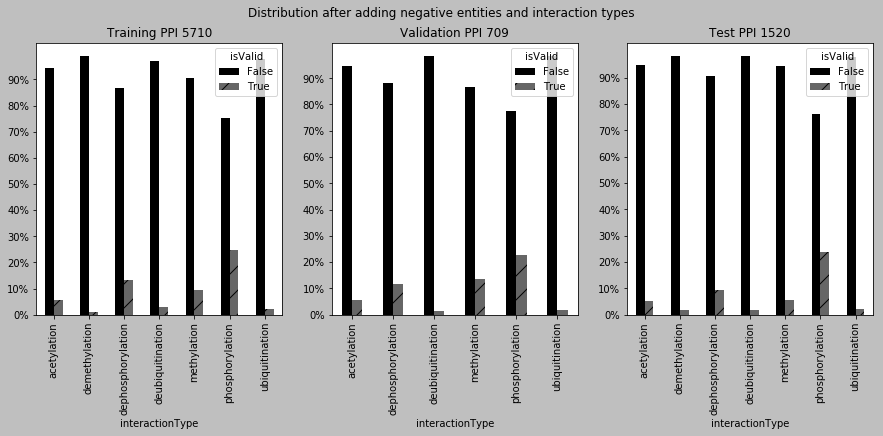

In [79]:

fig, ax = plt.subplots( 1,3, figsize=(15,5))

plot_negative_distribution(train,  val, test, "Distribution after adding negative entities and interaction types",fig, ax)
plt.savefig("EntityInteractionNegativeSample.png",bbox_inches = "tight")
plt.savefig("EntityInteractionNegativeSample.svg",bbox_inches = "tight")
plt.show()

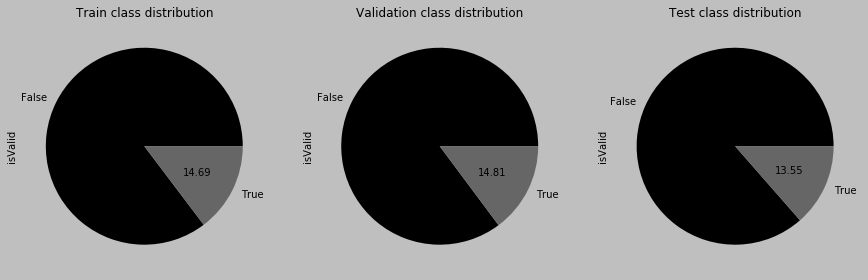

In [80]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("Interaction.png")

In [81]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,478,29
demethylation,419,4
dephosphorylation,716,108
deubiquitination,424,12
methylation,468,48
phosphorylation,1925,629
ubiquitination,441,9


In [82]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,128,7
demethylation,114,2
dephosphorylation,191,20
deubiquitination,115,2
methylation,116,7
phosphorylation,523,165
ubiquitination,127,3


In [83]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,69,4
dephosphorylation,82,11
deubiquitination,67,1
methylation,58,9
phosphorylation,271,79
ubiquitination,57,1


In [84]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,128,7
demethylation,114,2
dephosphorylation,191,20
deubiquitination,115,2
methylation,116,7
phosphorylation,523,165
ubiquitination,127,3


In [85]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,69,4
dephosphorylation,82,11
deubiquitination,67,1
methylation,58,9
phosphorylation,271,79
ubiquitination,57,1


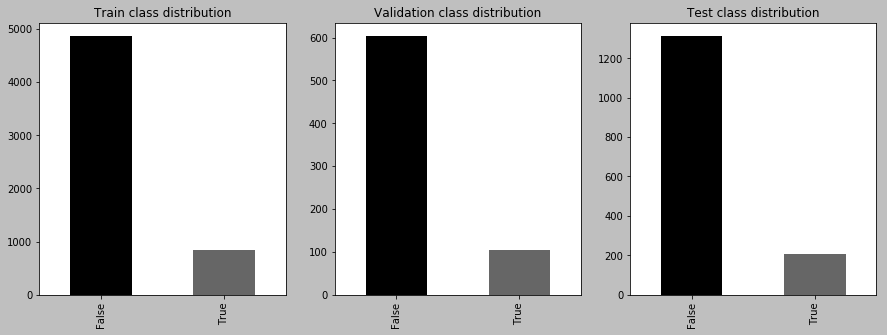

In [86]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.bar( ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.bar( ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.bar( ax=ax[2])



plt.savefig("Interaction.png")

In [87]:
train.to_json("train_unique_pub_v6_max_neg.json")
test.to_json("test_unique_pub_v6_max_neg.json")
val.to_json("val_unique_pub_v6_max_neg.json")

In [88]:
train.sample(n=20).to_json("sample_train.json")

In [89]:
train.query('isValid == True').sample(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
5640,7,True,595251,phosphorylation,True,True,"[[abl1_mouse], [Tyrosine-protein kinase ABL1], [Abl1], [Abl], [Abelson murine leukemia viral oncogene homolog 1], [Proto-oncogene c-Abl], [p150], [Abelson tyrosine-protein kinase 1]]",P00520,"[[cdn1b_human], [Cyclin-dependent kinase inhibitor 1B], [Cyclin-dependent kinase inhibitor p27], [p27Kip1], [CDKN1B], [KIP1]]",P46527,2,17254966,None,"p27Kip1 controls cell proliferation by binding to and regulating the activity of cyclin-dependent kinases (Cdks). Here we show that Cdk inhibition and p27 stability are regulated through direct phosphorylation by tyrosine kinases. A conserved tyrosine residue (Y88) in the Cdk-binding domain of p27 can be phosphorylated by the Src-family kinase Lyn and the oncogene product BCR-ABL. Y88 phosphorylation does not prevent p27 binding to cyclin A/Cdk2. Instead, it causes phosphorylated Y88 and the entire inhibitory 3(10)-helix of p27 to be ejected from the Cdk2 active site, thus restoring partial Cdk activity. Importantly, this allows Y88-phosphorylated p27 to be efficiently phosphorylated on threonine 187 by Cdk2 which in turn promotes its SCF-Skp2-dependent degradation. This direct link between transforming tyrosine kinases and p27 may provide an explanation for Cdk kinase activities observed in p27 complexes and for premature p27 elimination in cells that have been transformed by activated tyrosine kinases.","P46527 controls cell proliferation by binding to and regulating the activity of cyclin-dependent kinases (Cdks). Here we show that Cdk inhibition and O60232 stability are regulated through direct phosphorylation by tyrosine kinases. A conserved tyrosine residue (Y88) in the Cdk-binding domain of O60232 can be phosphorylated by the Src-family kinase P07948 and the oncogene product P00519. Y88 phosphorylation does not prevent O60232 binding to P20248/P24941. Instead, it causes phosphorylated Y88 and the entire inhibitory 3(10)-helix of O60232 to be ejected from the P24941 active site, thus restoring partial Cdk activity. Importantly, this allows Y88-phosphorylated O60232 to be efficiently phosphorylated on threonine 187 by P24941 which in turn promotes its P21583-Q13309-dependent degradation. This direct link between transforming tyrosine kinases and O60232 may provide an explanation for Cdk kinase activities observed in O60232 complexes and for premature O60232 elimination in cells that have been transformed by activated tyrosine kinases.",False,True,False,False
5270,2,True,1271034,dephosphorylation,True,True,"[[pp1a_rabit], [Serine/threonine-protein phosphatase PP1-alpha catalytic subunit], [PPP1CA], [PPP1A]]",P62139,"[[nmde2_human], [Glutamate receptor ionotropic, NMDA 2B], [GRIN2B], [NMDAR2B], [N-methyl D-aspartate receptor subtype 2B], [N-methyl-D-aspartate receptor subunit 3], [Glutamate [NMDA] receptor subunit epsilon-2]]",Q13224,2,19453375,None,"Ca(2+) influx through NMDA-type glutamate receptor at excitatory synapses causes activation of post-synaptic Ca(2+)/calmodulin-dependent protein kinase type II (CaMKII) and its translocation to the NR2B subunit of NMDA receptor. The major binding site for CaMKII on NR2B undergoes phosphorylation at Ser1303, in vivo. Even though some regulatory effects of this phosphorylation are known, the mode of dephosphorylation of NR2B-Ser1303 is still unclear. We show that phosphorylation status at Ser1303 enables NR2B to distinguish between the Ca(2+)/calmodulin activated form and the autonomously active Thr286-autophosphorylated form of CaMKII. Green fluorescent protein-alpha-CaMKII co-expressed with NR2B sequence in human embryonic kidney 293 cells was used to study intracellular binding between the tw